# Assignment 2
### Scientific Computing

Nitai Nijholt (12709018)

Pablo Rodriguez Alves (15310191)

In [147]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

from math import floor
from time import sleep
from numba import njit

In [148]:
# Module with diffusion code from Assignment 1
from diffusion_module import update_sor

In [149]:
np.random.seed(42)

## 1. Diffusion Limited Aggregation

### A.1 Implement growth model

In [150]:
# Global parameters
N = 100
ETA = 1
STEPS = 100
CONCENTRATION_SOLVING_THRESHOLD = 0.001 # For concentration solving
w = 2/(1 + np.sin(np.pi * (1/(N + 1)) ))


# Flags
SHOW_STARTING_CONDITIONS = True
SAVE_CLUSTER_EVOLUTION = True

In [151]:
# Innitialization
# of concentrations, cluster and candidate growth probabilities
concentrations = np.zeros((N,N))
cluster = np.zeros((N,N))
candidates = np.zeros((N,N))

## 1. Concentration is set to analytical result
for i in range(N):
    concentrations[i,:] = 1 - i/(N-1)

## 2. Innitial cluster is set as a small square at the bottom
# If we want a 2x2 square, use this: cluster[N-2:N,int(N/2-1):int(N/2+1)] = 1
cluster[N-1,int(N/2)] = 1

C:\Users\Pablo\AppData\Local\Temp\ipykernel_3140\2991715646.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_bad(color='black')


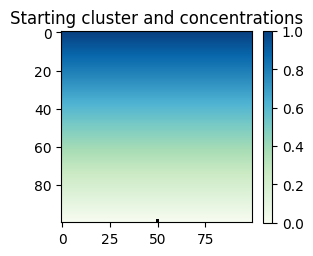

In [152]:
# Plotting of starting conditions
# Colorbar settings based on:
# https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color

if SHOW_STARTING_CONDITIONS:
    # Combine concentrations and cluster for showing
    lattice = concentrations + cluster
    masked_array = np.ma.masked_where(cluster == 1, lattice)
    
    # Select the colormap and the color for the exception values
    cmap = matplotlib.cm.GnBu
    cmap.set_bad(color='black')
    
    # Plot the total lattice
    # For exporting this to report, we should add dpi=400
    plt.figure(figsize=(3,3))
    plt.imshow(masked_array, cmap=cmap)
    plt.title('Starting cluster and concentrations')
    plt.colorbar(fraction=0.0455, pad=0.05)
    plt.tight_layout()
    plt.show()

In [156]:
# SOC solving until stop_thresold
def solve_SOR(concentrations,cluster,stop_thresold,N):

    # TODO: Move this to function parameters
    MAX_ITERATIONS = 20

    h = 1/(N + 1)
    w = 2/(1 + np.sin(np.pi * h))

    # At the top we have c=1, and c=0 at the bottom
    # TODO: Check if this is the case
    concentrations[0,:] = 1
    concentrations[N-1,:] = 0
    
    # Where we have our cluster it behaves as insulating material
    iteration = 1
    old_c = concentrations

    while(iteration < MAX_ITERATIONS):
        # TODO: Call sor_updated
        new_c = update_sor(old_c,cluster,N,w)        

        # TODO: Compute difference in concent.
        delta = np.max(np.abs(new_c - old_c))

        # TODO: Check if we change less than stop_thresold
        if delta < stop_thresold:
            break
        else:
            old_c = new_c
            iteration +=1
        


    # TODO: Implement as done in assignment 1
    return new_c

def is_neighboor_in_bounds(neighboor,N):
    x,y = neighboor
    return True if (x >= 0 and x < N and y >= 0 and y < N) else False

# Locate growth candidates
def get_candidates(cluster,N):
    # Reset candidates
    candidates = np.zeros((N,N))

    # Get neighboor cells of cluster
    cluster_cell_coordinates = np.argwhere(cluster != 0)

    for cell in cluster_cell_coordinates:
        # Check neighboors        
        x,y = cell

        neighboors = [[x+1,y],[x-1,y],[x,y+1],[x,y-1]]

        for neighboor in neighboors:
            xn,yn = neighboor
            if is_neighboor_in_bounds(neighboor,N):
                if cluster[xn,yn] != 1:
                    candidates[xn,yn] = 1
                    
        # add as candidate!

    return candidates

def get_candidate_probabilities(candidates,concentrations,N,eta):
    # Innitialize matrix for probabilities
    probability_growth = np.zeros((N,N))

    candidates_coordinates = np.argwhere(candidates != 0)

    # Get sum of concentrations at candidate points
    candidate_c_sum = np.sum(np.power(concentrations[candidates != 0],eta))    
    
    # Old way
    #candidate_c_sum = 0
    #for cell in candidates_coordinates:
    #    x,y = cell
    #    candidate_c_sum += concentrations[x,y]**eta

    # Iterate all candidates!
    # TODO: Optimize This could again be done with numpy syntax in one line
    for cell in candidates_coordinates:
        x,y = cell
        probability_growth[x,y] = np.power(concentrations[x,y],eta) / candidate_c_sum

    return probability_growth


def coordinates_chosen_one(probability_growth,N):
    # Get candidates in 1D and probabilities in 1D
    cands = np.arange(0, N**2)

    probs = probability_growth.ravel()

    choice = np.random.choice(cands,p=probs)
    
    #print(choice)
    # Get coordinates of element choice
    
    # Get coordinate
    x = floor(choice/N)
    y = choice % N
    return x,y

# Choose one candidate
# Update the cluster with that value


In [157]:
def update(cluster,concentrations,stop_thresold,N):
    # 1. Solve time-indep Eq (like Laplace)
    ## 1.1 Make concentrations at cluster be 0
    concentrations[cluster==1] = 0

    ## 1.2 Solve concentrations!
    concentrations = solve_SOR(concentrations,cluster,stop_thresold,N)
    
    # 2. Locate growth candidates around cluster
    candidates = get_candidates(cluster,N)
    probability_growth = get_candidate_probabilities(candidates,concentrations,N,ETA)

    """
    print(candidates)
    print(probability_growth)
    plt.imshow(probability_growth)
    plt.show()
    """

    # 3. A single candidate is added with probability p_g
    x,y = coordinates_chosen_one(probability_growth,N)
    
    # And then it is added to the cluster
    cluster[x,y] = 1

    return cluster,concentrations,probability_growth



In [158]:
# Repeat from 1 for a large number of growh_steps

if SAVE_CLUSTER_EVOLUTION:
    # Prepare to save all clusters
    total_clusters = np.zeros((N,N,STEPS))
    total_concentrations = np.zeros((N,N,STEPS))
    total_probability_growth = np.zeros((N,N,STEPS))
    # Save starting cluster
    total_clusters[:,:,0] = cluster

# Main simulation loop
  
for step in range(STEPS-1):
    
    cluster,concentrations,probability_growth = update(cluster,concentrations,CONCENTRATION_SOLVING_THRESHOLD,N)

    if SAVE_CLUSTER_EVOLUTION:
        total_clusters[:,:,step+1] = cluster
        total_concentrations[:,:,step+1] = concentrations
        total_probability_growth[:,:,step+1] = probability_growth

In [159]:
# Save results
if SAVE_CLUSTER_EVOLUTION:
    np.save(f'DLA_clusters_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_clusters)
    np.save(f'DLA_concents_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_concentrations)
    np.save(f'DLA_probabil_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_probability_growth)

In [15]:
# Load results
total_clusters = np.load(f'DLA_clusters_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_concentrations = np.load(f'DLA_concents_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_probability_growth = np.load(f'DLA_probabil_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_3140\540619433.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_bad(color='black')


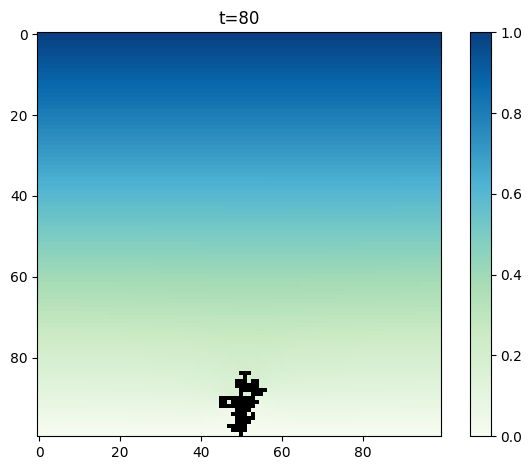

In [160]:
t=80
lattice = total_concentrations[:,:,t] + total_clusters[:,:,t]
masked_array = np.ma.masked_where(total_clusters[:,:,t] == 1, lattice)

# Select the colormap and the color for the exception values
cmap = matplotlib.cm.GnBu
cmap.set_bad(color='black')        

# Plot the total lattice
plt.imshow(masked_array, cmap=cmap)
plt.title(f't={t}')
plt.colorbar(fraction=0.0455, pad=0.05)
plt.tight_layout()

In [147]:
# Function for animation of cluster and concentration, based on Assignment 1
def save_animation(clusters,concentrations, interval=250,fps=10,name='animation.mp4'):
        
    plt.figure(figsize=(3, 3), layout='tight')

    def update(t):
        plt.clf()
        
        lattice = concentrations[:,:,t] + clusters[:,:,t]
        masked_array = np.ma.masked_where(clusters[:,:,t] == 1, lattice)
        
        # Select the colormap and the color for the exception values
        cmap = matplotlib.cm.GnBu
        cmap.set_bad(color='black')        

        # Plot the total lattice
        plt.imshow(masked_array, cmap=cmap)
        plt.title(f't={t}')
        plt.colorbar(fraction=0.0455, pad=0.05)
        plt.tight_layout()
        return plt

    anim = animation.FuncAnimation(plt.gcf(), update, frames=range(
            0, clusters.shape[2]), interval=interval)

    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)

In [73]:
# Function for animation of growth probability
def save_animation_probability(clusters,growth_probs, interval=250,fps=10,name='animation_probability.mp4',normalize=False):
        
    plt.figure(figsize=(3, 3), layout='tight')

    def update(t):
        plt.clf()
        
        lattice = growth_probs[:,:,t] + clusters[:,:,t]
        masked_array = np.ma.masked_where(clusters[:,:,t] == 1, lattice)
        
        # Select the colormap and the color for the exception values
        cmap = matplotlib.cm.GnBu.copy()
        cmap.set_bad(color='black')        

        # Plot the total lattice
        if normalize:
            masked_array = masked_array / np.max(growth_probs[:,:,t])

        plt.imshow(masked_array, cmap=cmap, vmin=0, vmax=1)
        plt.title(f't={t}')
        plt.colorbar(fraction=0.0455, pad=0.05)
        plt.tight_layout()
        return plt

    anim = animation.FuncAnimation(plt.gcf(), update, frames=range(
            0, clusters.shape[2]), interval=interval)

    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)

In [22]:
save_animation(total_clusters,total_concentrations, interval=250,fps=30,name=f'animation_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.mp4')

NameError: name 'save_animation' is not defined

C:\Users\Pablo\AppData\Local\Temp\ipykernel_41084\2845282845.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_bad(color='black')


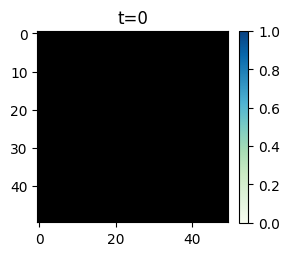

In [29]:
# Growth probability animation
save_animation_probability(total_clusters,total_probability_growth, interval=250,fps=30,name=f'animation_prob_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.mp4',normalize=True)
      

### A.2 Run a number of growth simulations

In [ ]:
# TODO

ETAS = [0,0.5,1,2,3,5,10,20,50,100]


### A.3 Investigate the influence of the $\eta$ parameter

In [59]:
# TODO Twist c_ij to eta
# Given single value of cluster
# Plot probabilities for different eta values!
#N = 50
#STEPS = 100
#CONCENTRATION_SOLVING_THRESHOLD = 0.001

N = 100
STEPS = 500
CONCENTRATION_SOLVING_THRESHOLD = 0.001

total_clusters = np.load(f'DLA_clusters_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_concentrations = np.load(f'DLA_concents_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_probability_growth = np.load(f'DLA_probabil_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')


In [60]:
t = 25

cluster = total_clusters[:,:,t]
concentrations = total_concentrations[:,:,t]
probability_growth = total_probability_growth[:,:,t]

In [111]:
ETAS = [0,1,10,100]

candidates = get_candidates(cluster,N)
pgrowth_totals = np.zeros((N,N,len(ETAS)))

for i in range(len(ETAS)):
    eta = ETAS[i]
    pgrowth_totals[:,:,i] = get_candidate_probabilities(candidates,concentrations,N,eta)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_55272\1227473321.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cividis").copy()
  cmap.set_bad(color='black')


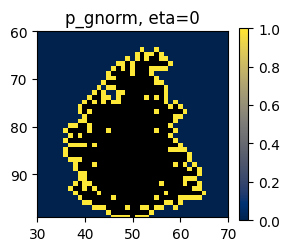

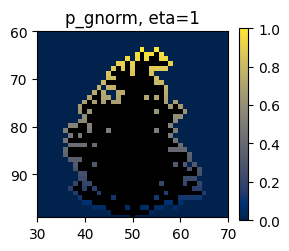

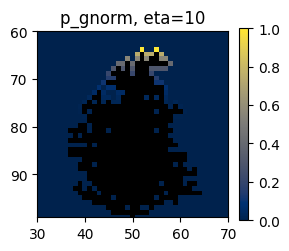

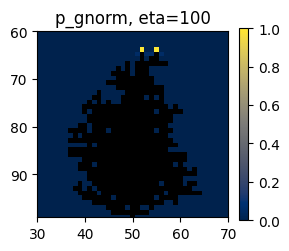

In [112]:
# Plot normalized growth probabilities for all etas!

for i in range(len(ETAS)):

    plt.figure(figsize=(3, 3), layout='tight')
    #plt.clf()
    
    lattice = pgrowth_totals[:,:,i] + cluster
    masked_array = np.ma.masked_where(cluster == 1, lattice)
    
    # Select the colormap and the color for the exception values
    cmap = matplotlib.cm.cividis
    cmap.set_bad(color='black')        

    # Plot the total lattice
    #if normalize:
    
    # Normalize array!!!
    masked_array = masked_array / np.max(pgrowth_totals[:,:,i])
    
    #print(plt.gca().get_ylim())
    
    plt.imshow(masked_array, cmap=cmap, vmin=0, vmax=1)

    plt.xlim([30,70])
    plt.ylim([99,60])
 

#extent=[-4.50,4.50,0,3]
    plt.title(f'p_gnorm, eta={ETAS[i]}')
    plt.colorbar(fraction=0.0455, pad=0.05)
    plt.tight_layout()

Easy to see that eta=0 means equiprobability in all candidates and eta->inf means growth in the spot with maximun concentration, or equivalently,
same probability among all the points with maximun concentration

### OPTIONAL - Reduce the time required to solve the diffusion equation

In [ ]:
# TODO
# numbea!

## 2. Monte Carlo Simulation of DLA

### B.1 Implement the Monte Carlo version of DLA

In [6]:
# Global parameters
N = 50
STEPS = 100
STICKING_PROBABILITY = 1

# Flags
SHOW_STARTING_CONDITIONS = True
SAVE_CLUSTER_EVOLUTION = True

In [7]:
# Innitialization
cluster = np.zeros((N,N))
cluster[0,3] = 1

In [8]:
if SAVE_CLUSTER_EVOLUTION:
    total_clusters_RW = np.zeros((N,N,STEPS))
    total_clusters_RW[:,:,0] = cluster

In [66]:
# Function for animation of cluster and concentration, based on Assignment 1
def rw_animation(rw_locations, interval=250,fps=10,name='rw_animation.mp4'):

    plt.figure(figsize=(3, 3), layout='tight')
    
    def update(t):
        plt.clf()

        # Create empty matrix
        matrix = np.zeros((N,N))

        # TODO: Divide matrix by a value to leave trace
        # of older positions
        # matrix = matrix/2
        
        # Add 1 to the location
        x,y = rw_locations[t,:]
        matrix[int(x),int(y)] = 1

        # TODO: Show trace of previous steps

        plt.imshow(matrix)
        plt.title(f't={t} (RW)')
        plt.colorbar(fraction=0.0455, pad=0.05)
        plt.tight_layout()
        return plt

    anim = animation.FuncAnimation(plt.gcf(), update, frames=range(
            0, rw_locations.shape[0]), interval=interval)

    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)

In [10]:
def get_RW(cluster,N):
    # Get candidates in top row to start the RW    
    available_spots = np.argwhere(cluster[0,:] == 0)
    
    # Continue only if there is still space to add RW at the top
    #if available_spots == []:
    #    print('First row filled, cant add RW!')
    #    return 0,0,True

    # Pick one of the available spots at the top for the RW
    chosen = np.random.randint(0, len(available_spots)+1)

    # TODO: Check if the -1 and previous +1 add up correctly
    rw_x = available_spots[chosen-1]
    rw_y = 0

    return rw_x,rw_y

def move_RW(x,y,N):
    # Gives the coordinates of the new RW position and
    # True or false in the 3rd argument if there was horizontal connection
    # It also does horizontal connection if neccesary
    # But it does not check if the new position if out of bounds

    # Axis of the movement: 0 for x, 1 for y
    movement_axis = np.random.choice([0,1])
    offset = np.random.choice([-1,1])

    if movement_axis==0:
        # Move in x axis
        return x+offset,y,False
    else:
        # Movement in y axis 
        # Check if we connecct with other side
        if y==0 and offset == -1:
            return x,N-1,True
        elif y==(N-1) and offset == 1:
            return x,0,True
        else:
            return x,y+offset,False


RW OUT!


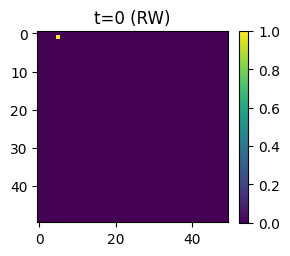

In [11]:
"""
RW test: Evolution in time
"""
N = 50
RW_STEPS = 100
x0,y0 = 0,5

RW_evolution = np.zeros((RW_STEPS,2))


for i in range(RW_STEPS):

    x,y,_ = move_RW(x0,y0,N)
    RW_out = bool(x<0 or x==N)

    #print(i,x,y)

    
    if RW_out:
        print('RW OUT!')
        break
    # See if new location is cluster!
    #elif cluster[x,y] == 1:
        # Previous location was neighboor: add to cluster
    #    # TODO: Add probability p_s
    #    cluster[x0,y0] = 1
    else:
        # For animation, save location
        RW_evolution[i,:] = x,y

        # Continue!
        x0,y0 = x,y



# Do animation up to i
rw_animation(RW_evolution[:i,:], interval=250,fps=10,name='rw_animation.mp4')


In [93]:
def update_RW(cluster,N,sticking_probability):
    # Check if we can still add new RWs at the top!
    if np.all(cluster[0,:] == 1):
        print("First row full, can't add more RW, aborting!")
        return cluster,True

    # Create RWs until they stick to cluster
    RW_added = False

    while(not RW_added):
        # Get a new RW
        x0,y0 = get_RW(cluster,N)

        # Move the RW until something happens...
        # Either the RW goes outside the map or gets added
        while(not RW_added):
            x,y,just_moved_to_other_side = move_RW(x0,y0,N)
            RW_out = bool(x<0 or x==N)

            if RW_out:
                #print('RW OUT! -> New RW')
                break
            elif cluster[x,y] == 1 and not just_moved_to_other_side:
                # New location is cluster!
                # Previous location was neighboor: add to cluster
                accept = np.random.binomial(1, sticking_probability)
                if accept:
                    cluster[x0,y0] = 1

                    RW_added = True
                    return cluster,True
                else:
                    # Reject movement to leader!
                    # x,y = x,y
                    pass
            else:
                # Continue moving!
                x0,y0 = x,y

    #return cluster,full


In [94]:
# Main simulation loop
N = 15
STEPS = 50
STICKING_PROBABILITY = 0.5

In [95]:
# First cluster
cluster = np.zeros((N,N))
cluster[N-1,int(N/2)] = 1

total_clusters_RW = np.zeros((N,N,STEPS))
total_clusters_RW[:,:,0] = cluster

In [96]:
# Simulation
for step in range(STEPS-1):    
    cluster,full = update_RW(cluster,N,STICKING_PROBABILITY)
    total_clusters_RW[:,:,step+1] = cluster

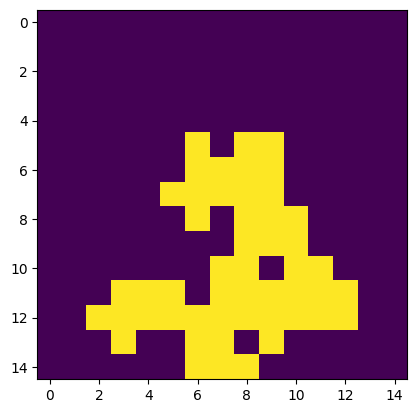

In [97]:
# Visualize last cluster
plt.imshow(cluster)

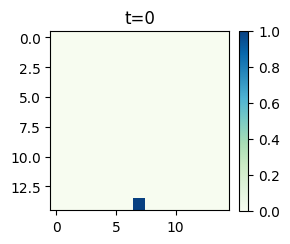

In [98]:
total_concentrations = np.zeros((N,N,STEPS))
save_animation_probability(total_concentrations,total_clusters_RW, interval=250,fps=30,name=f'RW_evolution_N{N}_s{STEPS}_p{STICKING_PROBABILITY}.mp4',normalize=True)
     
#rw_animation(total_clusters_RW, interval=250,fps=30,name=f'RW_animation_{N}_{STEPS}.mp4')

### B.2 Compare the resulting cluster to those obtained with the diffusion equation

- We will use fractal dimension of the clusters created with both methods.

- 2

- Log-log plot


In [ ]:
# https://porespy.org/examples/metrics/tutorials/computing_fractal_dim.html
# https://github.com/ksenia007/dlaCluster
# https://phas.ubc.ca/~berciu/TEACHING/PHYS349/DLA.pdf

# Fractal dimension is slope of plot with
# N_e: number of cluster elements Within certain 
# R: radius around starting cluster point
# We compute N_e for many R values
# And compute the dimension like this: 
D = log(N_e)/log(R)


In [ ]:
# TODO

### C.1 Run the simulation for different values of $p_s$

In [ ]:
# TODO

### C.2 Plot the results

In [ ]:
# TODO

### C.3 How does cluster shape depend on $p_s$?

In [ ]:
# TODO

We could optimize the RW by making the RW spawn in the lowest row possible that has no cluster!

That way we would avoid going 99 rows down in the beginning!

## 3. The Gray-Scott model

### D.1 Implement the Gray-Scott model in 2D

In [ ]:
# TODO

### D.2 Explain the discretization and implementation

In [ ]:
# TODO

### D.3 Plot the resulting concentrations of U and V for several parameter choices

In [ ]:
# TODO

### D.4 Try adding a small amount of noise

In [ ]:
# TODO